<a href="https://colab.research.google.com/github/Deathonation/myMLproject/blob/main/BDA_strokeDataAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [507]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
np.set_printoptions(precision=4)
from sklearn.metrics import accuracy_score, recall_score, precision_score,f1_score, confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
import warnings
warnings.filterwarnings('ignore')
from sklearn.impute import KNNImputer

# from sklearn.linear_model import LogisticRegression
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.svm import LinearSVC, SVC

In [508]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [509]:
df1 = pd.read_csv('/content/drive/MyDrive/KAGGLE/stroke kaggle/healthcare-dataset-stroke-data.csv')
df1.head(5)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [510]:
df[['gender','id']].groupby(['gender']).count()

,id
gender,
Female,2994
Male,2115


In [511]:
df = df[df['gender']!='Other']
df.head(5)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,30.471292,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1


In [512]:
df.isnull().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [513]:
mean_bmi_has_stroke = df[df['stroke']==1]['bmi'].mean()
mean_bmi_has_stroke

30.47129186602873

In [514]:
mean_bmi_no_stroke = df[df['stroke']==0]['bmi'].mean()
mean_bmi_no_stroke

28.82443072994256

In [515]:
df.loc[df['stroke']==1,'bmi'] = df.loc[df['stroke']==1, 'bmi'].fillna(mean_bmi_has_stroke)
df.loc[df['stroke']==0,'bmi'] = df.loc[df['stroke']==0, 'bmi'].fillna(mean_bmi_no_stroke)

In [516]:
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,30.471292,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,28.824431,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.000000,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.600000,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.600000,formerly smoked,0


In [517]:
df[['stroke','id']].groupby(['stroke']).count().reset_index()

,stroke,id
0,0,4860
1,1,249


In [518]:
df_all = df.copy()

df_stroke = df[df['stroke']==1]

df_non = df[df['stroke']==0]

In [519]:
def plot_pie(column, title="All"):
    fig,axs = plt.subplots(1,1)
    data = df_all[column].value_counts()
    plt.pie(data,autopct='%1.2f%%',labels=data.index)
    plt.title(title)
    plt.show()
    
def plot_hist(column, title="all"):
    plt.hist(df_all[column],density=True)
    plt.title(title)
    plt.show()

def plot_bar(column, sort=False, title="all"):
    if sort:
        data_all = df_all[column].value_counts().sort_index()
    else:
        data_all = df_all[column].value_counts()
    plt.bar(data_all.index,data_all)
    plt.title(title)
    plt.show()
    
def plot_bar_compare(column, sort=False):
    if sort:
        data_churned = df_stroke[column].value_counts().sort_index()
        data_nonchurned = df_non[column].value_counts().sort_index()
    else:
        data_churned = df_stroke[column].value_counts()
        data_nonchurned = df_non[column].value_counts()
    
    fig,axs = plt.subplots(2,1)
    plt.subplots_adjust(left=0, bottom=0, right=1, top=2, wspace=0, hspace=0.2)
    axs[0].bar(data_nonchurned.index,data_nonchurned)
    axs[0].title.set_text('No Stroke')
    axs[1].bar(data_churned.index,data_churned)
    axs[1].title.set_text('Has Stroke')
    plt.show()

def plot_hist_compare(column, bins=5):
    plt.hist([df_non[column], df_stroke[column]] , color=['c','r'])
    plt.legend(('No Stroke', 'Has Stroke'))
    plt.show()
    
def plot_pie_compare(column):
    data_churned = df_stroke[column].value_counts()
    data_nonchurned = df_non[column].value_counts()
    
    fig,axs = plt.subplots(2,1)
    plt.subplots_adjust(left=0, bottom=0, right=1, top=2, wspace=0, hspace=0.2)
    axs[0].pie(data_nonchurned,autopct='%1.2f%%',labels=data_nonchurned.index)
    axs[0].title.set_text('No Stroke')
    axs[1].pie(data_churned,autopct='%1.2f%%',labels=data_churned.index)
    axs[1].title.set_text('Has Stroke')
    plt.show()

def plot_boxplot(column, title=""):
    sns.boxplot(x="stroke", y=column, palette=["c", "r"],
            hue="stroke",  data=df_all).set_title(title, fontsize=15)

def check_median(column):
    data_churned = df_stroke[column].describe()
    data_nonchurned = df_non[column].describe()
    print('No Stroke: {}'.format(data_nonchurned['50%']))
    print('Has Stroke: {}'.format(data_churned['50%']))

def check_most(column):
    data_churned = df_stroke[column].value_counts()
    data_nonchurned = df_non[column].value_counts()
    print('No Stroke: {}'.format(data_nonchurned.index[0]))
    print('Has Stroke: {}'.format(data_churned.index[0]))

# Stroke

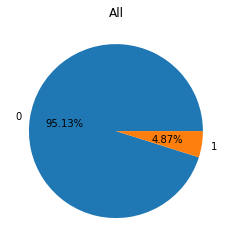

In [520]:

plot_pie('stroke')

# Gender

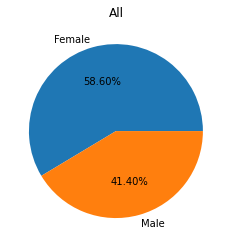

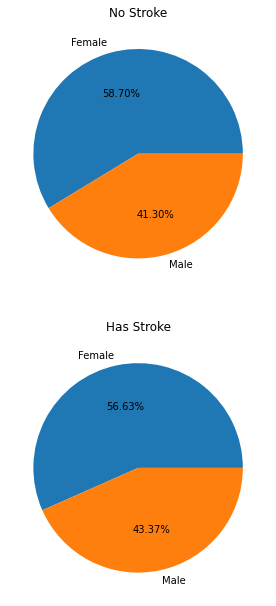

In [521]:
plot_pie('gender')
plot_pie_compare('gender')

# Age

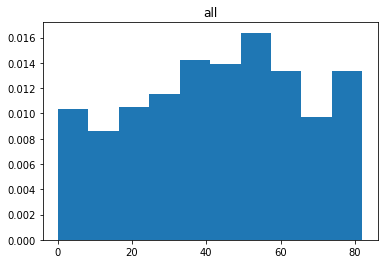

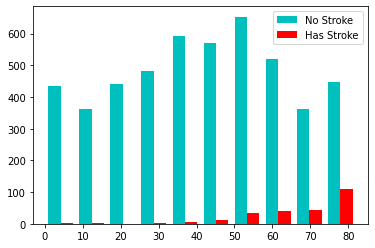

In [522]:
plot_hist('age')
plot_hist_compare('age')

In [523]:
check_median('age')

No Stroke: 43.0
Has Stroke: 71.0


# hypertension

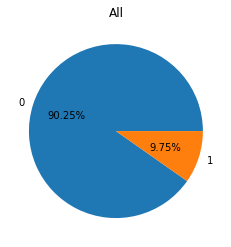

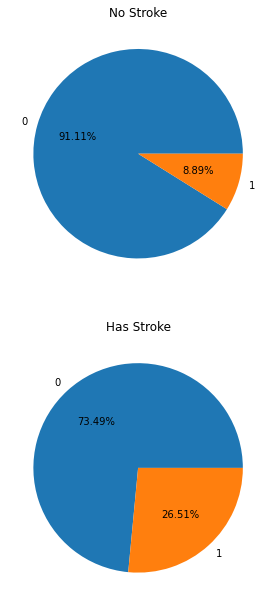

In [524]:
plot_pie('hypertension')
plot_pie_compare('hypertension')

In [525]:
check_most('hypertension')

No Stroke: 0
Has Stroke: 0


# heart_disease

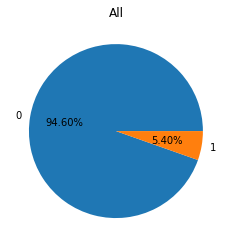

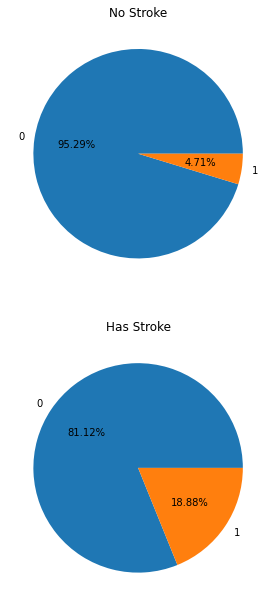

In [526]:
plot_pie('heart_disease')
plot_pie_compare('heart_disease')

# ever_married

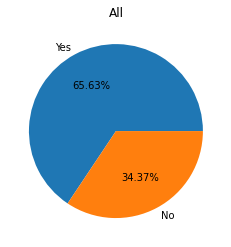

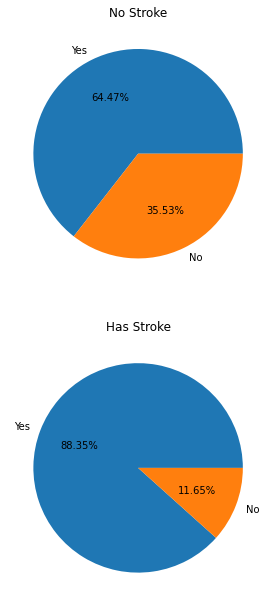

In [527]:
plot_pie('ever_married')
plot_pie_compare('ever_married')

In [528]:
check_most('ever_married')

No Stroke: Yes
Has Stroke: Yes


# work_type

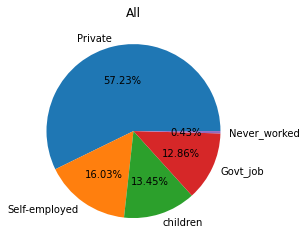

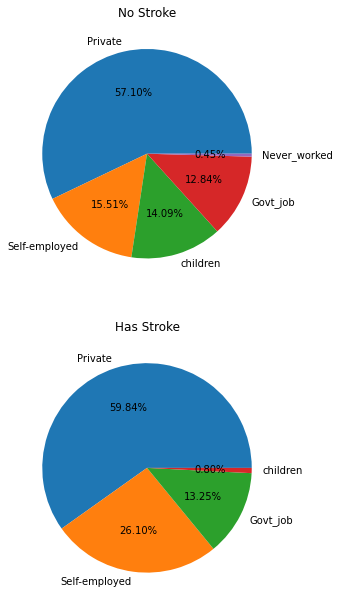

In [529]:
plot_pie('work_type')
plot_pie_compare('work_type')

# Residence_type

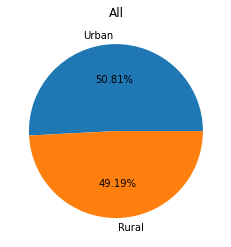

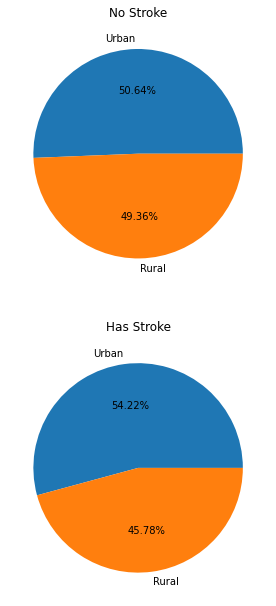

In [530]:
plot_pie('Residence_type')
plot_pie_compare('Residence_type')

# avg_glucose_level

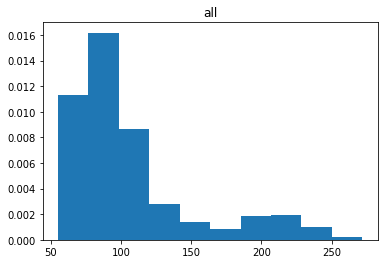

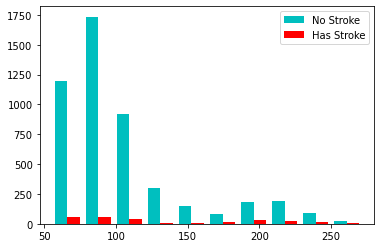

In [531]:
plot_hist('avg_glucose_level')
plot_hist_compare('avg_glucose_level')

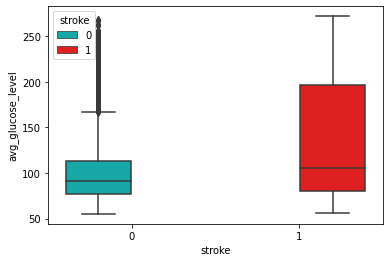

In [532]:
plot_boxplot('avg_glucose_level')

In [533]:
check_median('avg_glucose_level')

No Stroke: 91.465
Has Stroke: 105.22


# bmi

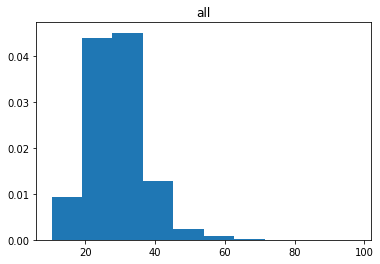

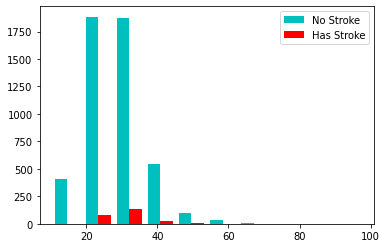

In [534]:
plot_hist('bmi')
plot_hist_compare('bmi')

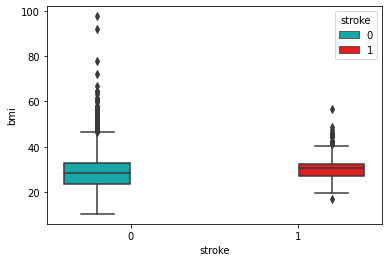

In [535]:
plot_boxplot('bmi')

In [536]:
check_median('bmi')

No Stroke: 28.3
Has Stroke: 30.47129186602871


In [537]:
3255/5109*100

63.711098062243096

# smoking_status

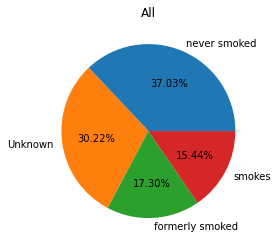

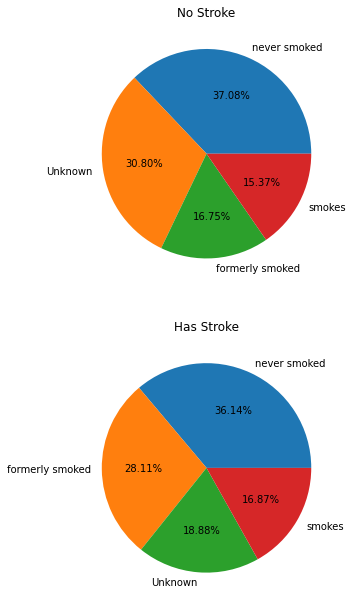

In [538]:
plot_pie('smoking_status')
plot_pie_compare('smoking_status')

### Data Visualization Result

| | No Stroke| Has Stroke | Note
| :- | :-: | :-: | :-: |
| gender (Most) | Female | Female | No Clear Difference
| age (Median) | 43 | 71 | the median age of stroke patients is higher than patient with no stroke
| hypertension (Most) | 0 | 0 | the patient who has hypertension from stroke patient is 18 % higher than the patient with no stroke
| heart_disease (Most) | 0 | 0 | the patient who has heart disease from stroke patient is 14 % higher than the patient with no stroke
| ever_married (Most) | Yes | Yes | the patient who ever married from stroke patient is 24 % higher than the patient with no stroke
| work_type (Most) | Private | Private | the patient who work as self-employed from stroke patient is 11.4% higher than the patient with no stroke
| Residence_type (Most) | Urban | Urban | No Clear Difference
| avg_glucose_level (Median) | 91.5 | 105.2 | the median of avg_glucose_level from Stroke Patient is higher than the Patient with no Stroke
| bmi (Median) | 28.3 | 30.5 | the median of bmi from Stroke Patient is little higher than the Patient with no Stroke
| smoking_status (Most) | never smoked | never smoked | The patient who smokes or formerly smoked from is 13% higher than the patient with no stroke

# PREPROCESSING

In [539]:
df1.head()


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [540]:
def onehot_encode(df, column):
  df3 = df.copy()
  dummies = pd.get_dummies(df3[column], prefix = column)
  df3 = pd.concat([df3,dummies],axis=1)
  df3 = df3.drop(column,axis=1)
  return df3

In [541]:
def preprocess_inputs(df):
  df = df.copy()
  
  #drop id
  df = df.drop('id',axis=1)

  # binary Encoding
  df['ever_married'] = df['ever_married'].replace({'No': 0,'Yes':1})
  df['Residence_type'] = df['Residence_type'].replace({'Rural': 0,'Urban':1})

  #one Hot encoding
  for column in ['gender','smoking_status','work_type']:
    df = onehot_encode(df,column=column)

  # split df into X and y
  y = df['stroke']
  X = df.drop('stroke',axis = 1)

  #train test split
  X_train,X_test, y_train, y_test =train_test_split(X,y, train_size = 0.7, shuffle= True, random_state = 1)

  # KNN imputation of missing values
  imputer = KNNImputer()
  imputer.fit(X_train)
  X_train = pd.DataFrame(imputer.transform(X_train), index=X_train.index, columns=X_train.columns)
  X_test = pd.DataFrame(imputer.transform(X_test), index=X_test.index, columns=X_test.columns)

  # Scale
  scaler = StandardScaler()
  scaler.fit(X_train)
  X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
  X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)

  return X_train,X_test, y_train, y_test

In [542]:
X_train,X_test, y_train, y_test = preprocess_inputs(df1)


In [543]:
X_train

,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,gender_Female,gender_Male,gender_Other,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children
4313,0.608843,-0.330374,-0.238161,0.719002,0.994146,0.638258,0.010074,-1.174021,1.174021,0.0,1.515511,-0.461023,-0.763376,-0.425344,-0.383679,-0.069103,0.864050,-0.438105,-0.392264
376,-1.886989,-0.330374,-0.238161,-1.390817,-1.005888,-0.386663,-1.754554,0.851774,-0.851774,0.0,1.515511,-0.461023,-0.763376,-0.425344,-0.383679,-0.069103,-1.157341,-0.438105,2.549304
4913,-1.036663,-0.330374,-0.238161,-1.390817,0.994146,-0.466196,-1.105794,-1.174021,1.174021,0.0,-0.659843,-0.461023,1.309970,-0.425344,-0.383679,-0.069103,0.864050,-0.438105,-0.392264
1791,-1.347974,-0.330374,-0.238161,-1.390817,-1.005888,0.697358,-1.404223,-1.174021,1.174021,0.0,1.515511,-0.461023,-0.763376,-0.425344,-0.383679,-0.069103,-1.157341,-0.438105,2.549304
2166,-0.680878,-0.330374,-0.238161,0.719002,-1.005888,1.401291,-0.236455,-1.174021,1.174021,0.0,1.515511,-0.461023,-0.763376,-0.425344,-0.383679,-0.069103,0.864050,-0.438105,-0.392264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2895,0.119639,-0.330374,-0.238161,0.719002,0.994146,0.704389,0.036024,-1.174021,1.174021,0.0,-0.659843,-0.461023,1.309970,-0.425344,-0.383679,-0.069103,0.864050,-0.438105,-0.392264
2763,0.075165,-0.330374,-0.238161,0.719002,-1.005888,-0.922303,0.386355,0.851774,-0.851774,0.0,1.515511,-0.461023,-0.763376,-0.425344,-0.383679,-0.069103,0.864050,-0.438105,-0.392264
905,-0.547458,-0.330374,-0.238161,0.719002,-1.005888,-0.647013,0.853462,0.851774,-0.851774,0.0,-0.659843,-0.461023,1.309970,-0.425344,-0.383679,-0.069103,0.864050,-0.438105,-0.392264
3980,0.075165,-0.330374,-0.238161,0.719002,-1.005888,2.469274,3.370652,0.851774,-0.851774,0.0,-0.659843,-0.461023,-0.763376,2.351036,-0.383679,-0.069103,0.864050,-0.438105,-0.392264


In [544]:
y_train

4313    0
376     0
4913    0
1791    0
2166    0
       ..
2895    0
2763    0
905     0
3980    0
235     1
Name: stroke, Length: 3577, dtype: int64

In [545]:
{column: len(X[column].unique()) for column in X.select_dtypes('object').columns}

{}

In [546]:
X_train.isna().sum()

age                               0
hypertension                      0
heart_disease                     0
ever_married                      0
Residence_type                    0
avg_glucose_level                 0
bmi                               0
gender_Female                     0
gender_Male                       0
gender_Other                      0
smoking_status_Unknown            0
smoking_status_formerly smoked    0
smoking_status_never smoked       0
smoking_status_smokes             0
work_type_Govt_job                0
work_type_Never_worked            0
work_type_Private                 0
work_type_Self-employed           0
work_type_children                0
dtype: int64

In [547]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, SVC

In [548]:
models = {
    "Logistic Regression": LogisticRegression(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "SVM Linear kernel":LinearSVC(),
    "SVM RBF kernel": SVC()
}

for name, model in models.items():
  model.fit(X_train, y_train)
  print(name + "trained.")

Logistic Regressiontrained.
K-Nearest Neighborstrained.
Decision Treetrained.
SVM Linear kerneltrained.
SVM RBF kerneltrained.


In [549]:
y_train.value_counts()

0    3411
1     166
Name: stroke, dtype: int64

In [550]:
print("Model Performance\n-------------------------")
for name, model in models.items():
  y_pred = model.predict(X_test)
  print(
      "\n" + name + "Accuracy: {:.3f}%\n\t\t\t\t         F1-Score: {:.5f}"\
      .format(accuracy_score(y_test, y_pred)*100, f1_score(y_test, y_pred))
  )

Model Performance
-------------------------

Logistic RegressionAccuracy: 94.586%
				         F1-Score: 0.00000

K-Nearest NeighborsAccuracy: 94.260%
				         F1-Score: 0.00000

Decision TreeAccuracy: 90.476%
				         F1-Score: 0.17978

SVM Linear kernelAccuracy: 94.586%
				         F1-Score: 0.00000

SVM RBF kernelAccuracy: 94.586%
				         F1-Score: 0.00000


In [551]:
models.values()

dict_values([LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False), KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform'), DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best'), LinearSVC(C=1.0, class_weight=None, dual=Tru

In [552]:
#handling class imbalance with over sampling - add duplicate values of possitive class 1 in stroke


In [553]:
oversampled_data = pd.concat([X_train, y_train], axis = 1)
num_samples = y_train.value_counts()[0]-y_train.value_counts()[1]
new_samples = oversampled_data.query("stroke==1").sample(num_samples, replace=True, random_state=1)
oversampled_data = pd.concat([oversampled_data, new_samples], axis = 0).sample(frac=1.0, random_state=1).reset_index(drop=True)

y_train_oversampled = oversampled_data['stroke']
X_train_oversampled = oversampled_data.drop('stroke', axis=1)


In [554]:
y_train_oversampled.value_counts()

1    3411
0    3411
Name: stroke, dtype: int64

In [555]:
oversampled_data['stroke'].value_counts()

1    3411
0    3411
Name: stroke, dtype: int64

In [556]:
for name, model in models.items():
  model.fit(X_train_oversampled, y_train_oversampled)
  print(name + "trained.")

Logistic Regressiontrained.
K-Nearest Neighborstrained.
Decision Treetrained.
SVM Linear kerneltrained.
SVM RBF kerneltrained.


In [557]:
print("Model Performance\n-------------------------")
for name, model in models.items():
  y_pred = model.predict(X_test)
  print(
      "\n" + name + "Accuracy: {:.3f}%\n\t\t\t\t         F1-Score: {:.5f}"\
      .format(accuracy_score(y_test, y_pred)*100, f1_score(y_test, y_pred))
  )

Model Performance
-------------------------

Logistic RegressionAccuracy: 73.190%
				         F1-Score: 0.25678

K-Nearest NeighborsAccuracy: 85.845%
				         F1-Score: 0.11429

Decision TreeAccuracy: 92.042%
				         F1-Score: 0.16438

SVM Linear kernelAccuracy: 72.929%
				         F1-Score: 0.25760

SVM RBF kernelAccuracy: 78.082%
				         F1-Score: 0.19617


## Conclusion : SvM works well with original data which has less positive target attributes i.e stroke = 1, But as this Data was having less positive target values we have to OVERSAMPLE the positive data to fix the imbalance in data and to improve relevance of data internally i.e to improve f1-score which is like an average of recall and precision. 